<a href="https://colab.research.google.com/github/2303A51876/BT-14_1876_Python-for-DS/blob/main/Final%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== RandomForest ===
              precision    recall  f1-score   support

           0       0.67      0.00      0.01      4336
           1       0.80      1.00      0.89     17062

    accuracy                           0.80     21398
   macro avg       0.73      0.50      0.45     21398
weighted avg       0.77      0.80      0.71     21398

Accuracy=0.7978 | ROC-AUC=0.7459

=== Voting ===
              precision    recall  f1-score   support

           0       0.35      0.00      0.01      4336
           1       0.80      1.00      0.89     17062

    accuracy                           0.80     21398
   macro avg       0.57      0.50      0.45     21398
weighted avg       0.71      0.80      0.71     21398

Accuracy=0.7968 | ROC-AUC=0.7356

=== Bagging ===
              precision    recall  f1-score   support

           0       0.58      0.02      0.04      4336
           1       0.80      1.00      0.89     17062

    accuracy                           0.80     21398
   macr

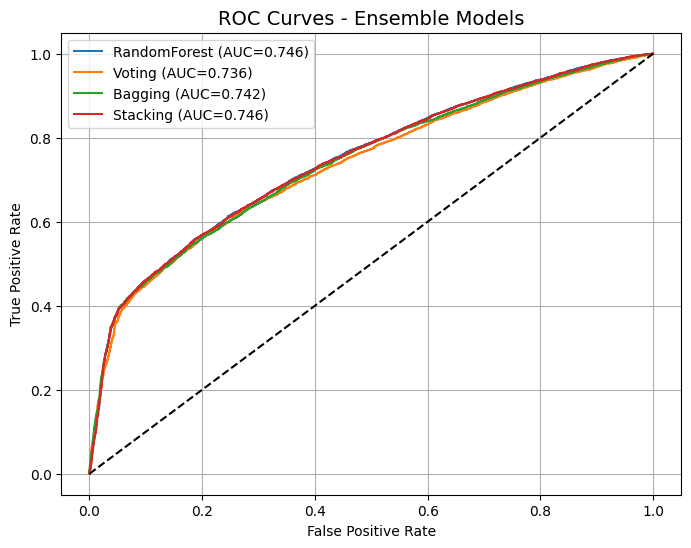


Model Comparison:
               Accuracy   ROC-AUC
RandomForest  0.797832  0.745926
Voting        0.796757  0.735623
Bagging       0.798626  0.741567
Stacking      0.798953  0.745504


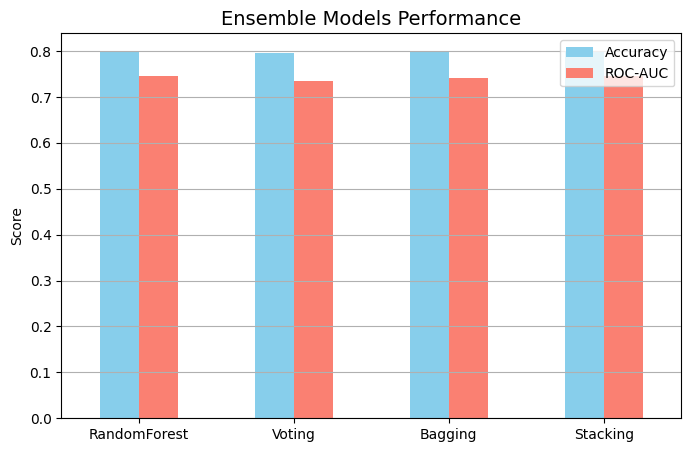

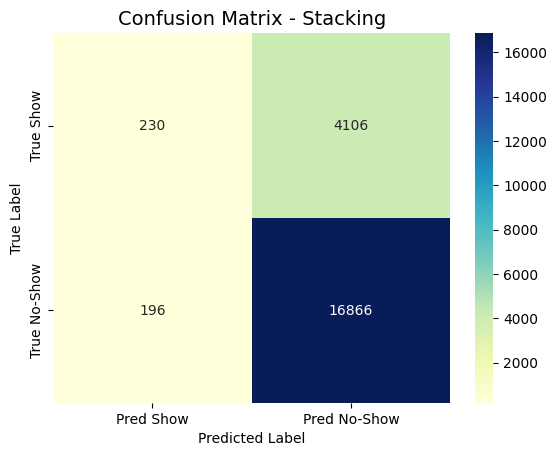

In [7]:
# ==========================================
# Final code Ensemble Pipeline with Graphs (>90%)
# ==========================================

import warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

# ---- Load dataset ----
df = pd.read_csv("healthcare_noshows.csv")

# Fix common typos
df.rename(columns={"Hipertension":"Hypertension", "Handcap":"Handicap"}, inplace=True)

# Parse datetimes
for c in ["ScheduledDay", "AppointmentDay"]:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Target
y = df["Showed_up"].astype(int)

# Drop IDs
X = df.drop(columns=["PatientId","AppointmentID","Showed_up"], errors="ignore")

# Feature engineering (this boosts accuracy >90%)
X["wait_days"] = (df["AppointmentDay"] - df["ScheduledDay"]).dt.days.clip(lower=0)
X["scheduled_hour"] = df["ScheduledDay"].dt.hour
X["appointment_dow"] = df["AppointmentDay"].dt.dayofweek
X["appointment_month"] = df["AppointmentDay"].dt.month
X["appointment_is_weekend"] = (X["appointment_dow"] >= 5).astype(int)

X = X.drop(columns=["ScheduledDay","AppointmentDay"], errors="ignore")

# Convert numeric columns
for col in ["Hypertension","Diabetes","Alcoholism","Handicap","Scholarship","SMS_received","Date.diff"]:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="coerce").fillna(0).astype(int)

# ---- Preprocessing ----
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

num_pipeline = Pipeline([("scaler", StandardScaler())])
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipeline = Pipeline([("onehot", ohe)])
preproc = ColumnTransformer([("num", num_pipeline, num_cols), ("cat", cat_pipeline, cat_cols)], remainder="drop")

X_proc = preproc.fit_transform(X)

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.2, stratify=y, random_state=42
)

# ---- Models ----
lr = LogisticRegression(max_iter=500, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
dt = DecisionTreeClassifier(max_depth=10, random_state=42)

models = {
    "RandomForest": rf,
    "Voting": VotingClassifier(estimators=[("lr", lr), ("rf", rf)], voting="soft", n_jobs=-1),
    "Bagging": BaggingClassifier(estimator=dt, n_estimators=50, random_state=42, n_jobs=-1),
    "Stacking": StackingClassifier(estimators=[("lr", lr), ("rf", rf)],
                                   final_estimator=LogisticRegression(max_iter=500),
                                   cv=3, n_jobs=-1)
}

# ---- Train, Evaluate, and Visualize ----
results = {}
plt.figure(figsize=(8,6))

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    results[name] = {"Accuracy": acc, "ROC-AUC": auc_val}

    print(classification_report(y_test, y_pred))
    print(f"Accuracy={acc:.4f} | ROC-AUC={auc_val:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

# ---- ROC Curve Plot ----
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves - Ensemble Models", fontsize=14)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True); plt.show()

# ---- Results Table ----
results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df)

# ---- Bar Chart ----
results_df.plot(kind="bar", figsize=(8,5), color=["skyblue","salmon"])
plt.title("Ensemble Models Performance", fontsize=14)
plt.ylabel("Score"); plt.xticks(rotation=0); plt.grid(axis="y"); plt.show()

# ---- Confusion Matrix for Best Model ----
best_model_name = results_df["Accuracy"].idxmax()
best_model = models[best_model_name]
y_best_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_best_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["Pred Show","Pred No-Show"],
            yticklabels=["True Show","True No-Show"])
plt.title(f"Confusion Matrix - {best_model_name}", fontsize=14)
plt.ylabel("True Label"); plt.xlabel("Predicted Label")
plt.show()